In [134]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from IPython.display import clear_output

In [2]:
!wget https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt

--2016-10-22 12:41:27--  https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt
Resolving ocw.mit.edu (ocw.mit.edu)... 104.108.36.226, 2a02:26f0:64:18d::18a8, 2a02:26f0:64:185::18a8
Connecting to ocw.mit.edu (ocw.mit.edu)|104.108.36.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5458199 (5.2M) [text/plain]
Saving to: 't8.shakespeare.txt'

100%[======================================>] 5,458,199    954KB/s   in 5.7s   

2016-10-22 12:41:34 (934 KB/s) - 't8.shakespeare.txt' saved [5458199/5458199]



In [22]:
with open('t8.shakespeare.txt') as file:
    raw_lines = [line.replace('\r',' ') for line in file.readlines()]
raw_text = ' '.join(raw_lines[300:-300])

In [23]:
vocab = list(set(raw_text))
trans_dic = {vocab[i]: i for i in range(len(vocab))}
raw_text_enc = [trans_dic[letter] for letter in raw_text]

define some parameters

In [122]:
text_size = len(raw_text_enc)
vocab_size = len(vocab)
num_neurons = 20
num_steps = 20
batch_size = 4000

In [136]:
text_size // batch_size

1389

function to generate batches of data

In [123]:
def gen_batch(raw_x, batch_size, num_steps):

    if batch_size % num_steps != 0:
        warnings.warn("Warning: batch size is not a multiple of num_steps.")
    
    raw_y = raw_x[1:] + [raw_x[0]]
    
    # partition raw data into batches and stack them vertically in a data matrix
    num_batch = len(raw_x) // batch_size
    data_x = np.zeros([num_batch, batch_size], dtype=np.int32)
    data_y = np.zeros([num_batch, batch_size], dtype=np.int32)
    
    for i in range(num_batch):
        data_x[i] = raw_x[batch_size * i:batch_size * (i + 1)]
        data_y[i] = raw_y[batch_size * i:batch_size * (i + 1)]
    
    # further divide batch partitions into num_steps for truncated backprop
    batch_lines = batch_size // num_steps

    for i in range(num_batch):
        x = np.zeros([batch_lines,num_steps],dtype=np.int32)
        y = np.zeros([batch_lines,num_steps],dtype=np.int32)
        for n in range(batch_lines):
            x[n,:] = data_x[i, n * num_steps:(n + 1) * num_steps]
            y[n,:] = data_y[i, n * num_steps:(n + 1) * num_steps]
        yield (x, y)

In [124]:
def gen_epochs(raw_data, num_epochs, batch_size, num_steps):
    for i in range(num_epochs):
        yield gen_batch(raw_data,batch_size,num_steps)

### define the graph

In [125]:
tf.reset_default_graph()

input layer:

In [126]:
x = tf.placeholder(tf.int32, [None, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [None, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size // num_steps, num_neurons])

#resulting tensor is of rank batch_size // num_steps x num_steps x vocab_size
x_one_hot = tf.one_hot(x, vocab_size)

hidden layer:

In [127]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_neurons)
rnn_output, final_state = tf.nn.dynamic_rnn(cell, x_one_hot, dtype=tf.float32)

output layer:

In [128]:
weight = tf.Variable(tf.truncated_normal([num_neurons, vocab_size], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[vocab_size]))

output = tf.reshape(rnn_output, [-1, num_neurons])
logits = tf.matmul(output, weight) + bias
prediction = tf.nn.softmax(logits)
prediction = tf.reshape(prediction, [-1, num_steps, vocab_size])

loss function:

In [129]:
target = tf.reshape(y,[-1])
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,target))

training:

In [130]:
optimizer = tf.train.AdamOptimizer()
trainOp = optimizer.minimize(loss)

In [137]:
init_vars = tf.initialize_all_variables()
trainHist = []
with tf.Session() as sess:
    sess.run(init_vars)
    for epoch in gen_epochs(raw_text_enc[:],1,batch_size,num_steps):
        for i, batch in enumerate(epoch):
            lossVal, _ = sess.run([loss,trainOp],feed_dict={x: batch[0], y: batch[1]})
            trainHist.append(lossVal)
            
            if i % 100 == 0:
                clear_output()
                print(i, lossVal)

(1300, 2.4068804)


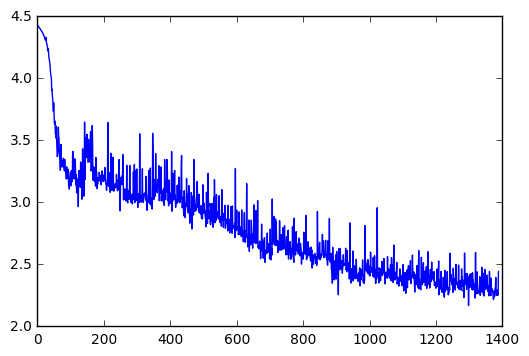

In [138]:
plt.plot(trainHist)

define output layer

In [ ]:
max_length = int(y.get_shape()[1])
out_size = int(y.get_shape()[2])



output = tf.reshape(output, [-1, num_neurons])
prediction = tf.nn.softmax(tf.matmul(output, weight) + bias)
prediction = tf.reshape(prediction, [-1, max_length, out_size])

cross_entropy = -tf.reduce_sum(
    target * tf.log(prediction), reduction_indices=[1])
cross_entropy = tf.reduce_mean(cross_entropy)

### train the network

In [38]:
def optimize(self):
        learning_rate = 0.003
        optimizer = tf.train.RMSPropOptimizer(learning_rate)
        return optimizer.minimize(self.cost)

In [ ]:
def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses

In [ ]:

for i in range(100):
    batch = gen_batch(raw_data, batch_size, num_steps)
    sess.run(model.optimize, {data: batch, target: y, dropout: 0.5})
    error = sess.run(model.error, {data: test.data, target: test.target, dropout: 1})
    print('error {:3.1f}%'.format(100 * error))

In [ ]:
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_outputs, W) + b ]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = [tf.squeeze(i, squeeze_dims=[1]) for i in tf.split(1, num_steps, y)]

loss_weights = [tf.ones([batch_size]) for i in range(num_steps)]
losses = tf.nn.seq2seq.sequence_loss_by_example(logits, y_as_list, loss_weights)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)
